Auteur: Konrad Hinsen

# Analyse de "L'Avare"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import numpy as np
from collections import defaultdict
from operator import add
from functools import reduce
import unicodedata
import urllib.request
import os

Nous utilisons des fonctionnalités introduites avec Python 3.7, c'est donc la version minimale réquise.

In [2]:
import sys
if sys.version_info.major < 3 or sys.version_info.minor < 7:
    print("Veuillez utiliser Python 3.7 (ou plus) !")

Veuillez utiliser Python 3.7 (ou plus) !


## Téléchargement

Nous utilisons le texte suivant :

In [3]:
text_url = 'https://dramacode.github.io/markdown/moliere_avare.txt'

Nous en faisons d'abord une copie locale :

In [4]:
text_file = 'moliere_avare.txt'
if not os.path.exists(text_file):
    urllib.request.urlretrieve(text_url, text_file)

## Lecture et analyse syntaxique du texte

Attention: le code dans cette partie dépend du format précis du texte!

In [5]:
text = open(text_file.strip(), 'r')

Les noms des acteurs apparaissent parfois en majuscule, parfois pas. L'usage des accents n'est pas non plus uniforme. Il est pratique d'introduire une forme normalisée, nous choisissons le tout majuscule et sans accents.

In [6]:
def normalized_name(name):
    return unicodedata \
        .normalize('NFKD', name) \
        .encode('ASCII', 'ignore') \
        .decode() \
        .upper()

D'abord nous lisons la liste des acteurs:

In [7]:
for line in text:
    if line.strip() == "# ACTEURS.":
        break
characters ={}
while True:
    line = next(text)
    if not line.startswith(" – "):
        break
    name, *description = line[3:].split(',')
    description = (','.join(description)).strip()
    characters[normalized_name(name)] = ({'name': name, 'description': description})
assert len(characters) == 14

Voici donc nos acteurs :

In [8]:
for name, record in characters.items():
    print(name)
    print(record)
    print()

HARPAGON
{'name': 'Harpagon', 'description': "Père de Cléante et d'Élise, et Amoureux de Mariane."}

CLEANTE
{'name': 'Cléante', 'description': "Fils d'Harpagon, Amant de Mariane."}

ELISE
{'name': 'Élise', 'description': "Fille d'Harpagon, Amante de Valère."}

VALERE
{'name': 'Valère', 'description': "Fils d'Anselme, et Amant d'Élise."}

MARIANE
{'name': 'Mariane', 'description': "Amante de Cléante, et aimée d'Harpagon."}

ANSELME
{'name': 'Anselme', 'description': 'Père de Valère et de Mariane.'}

FROSINE
{'name': 'Frosine', 'description': "Femme d'Intrigue."}

MAITRE SIMON
{'name': 'Maitre Simon', 'description': 'Courtier.'}

MAITRE JACQUES
{'name': 'Maitre Jacques', 'description': "Cuisinier et Cocher d'Harpagon."}

LA FLECHE
{'name': 'La Flèche', 'description': 'Valet de Cléante.'}

DAME CLAUDE
{'name': 'Dame Claude', 'description': "Servante d'Harpagon."}

BRINDAVOINE
{'name': 'Brindavoine', 'description': "laquais d'Harpagon."}

LA MERLUCHE
{'name': 'La Merluche', 'description':

Notons que le clerc du commaissaire est référencé, mais ne dit jamais rien. On peut l'ignorer.

Puis nous avançons au texte principal :

In [9]:
for line in text:
    if line.rstrip().startswith("# L'Avare"):
        break

Le reste du texte est une suite d'actes, dont chacun consiste de scènes. Chaque scène commence avec une liste des acteurs, sauf la scene VII de l'acte IV. Nous n'avons pas besoin de cette liste, parce que nous pouvons la reconstruire du dialogue. Nous ignorons donc cette ligne et n'analysons que le dialogue.

Dans le dialogue, chaque acteur est introduit sur une ligne qui commence avec quatre espaces, suivi par le nom de l'acteur, optionnellement suivi par un commentaire en gras (étoiles en Markdown), qui peut ou non être séparé par une virgule. Ceci rend l'extraction du nom un peu compliqué.

In [10]:
acts = []
scenes = None
scene = None
speech = None

for line in text:
    line = line.rstrip()
    if not line:
        continue
    if line.startswith("## "):
        scenes = []
        acts.append(scenes)
    elif line.startswith("### "):
        assert scenes is not None
        scene_characters = next(text)
        scene = []
        scenes.append(scene)
    elif line.startswith("    "):
        assert scene is not None
        character = normalized_name(line
                                    .lstrip()
                                    .split(',')[0]
                                    .split('*')[0]
                                    .rstrip(' .'))
        assert character in characters
        speech = []
        scene.append({'character': character, 'speech': speech})
    else:
        assert speech is not None
        speech.append(line)

Quelques petites vérifications s'imposent. Il est assez facile de compter les actes et scènes à la main, vérifions donc :

In [11]:
assert list(map(len, acts)) == [5, 5, 9, 7, 6]

Vérifions aussi que chaque scène contient un dialogue :

In [12]:
for scenes in acts:
    for scene in scenes:
        assert len(scene) > 0

## Qui parle le plus ?

Commençons par une vue globale: un tableau qui montre l'importance de chaque acteur. On résume le nombre de scènes où l'acteur apparaît, ainsi que le nombre de répliques qu'il prononce et le nombre total des mots que ces répliques contiennent.

In [13]:
n_scene = defaultdict(lambda: 0)
n_speech = defaultdict(lambda: 0)
n_word = defaultdict(lambda: 0)
for scenes in acts:
    for scene in scenes:
        in_scene = defaultdict(lambda: False)
        for part in scene:
            c = part['character']
            s = part['speech']
            in_scene[c] = True
            n_speech[c] += 1
            for line in s:
                n_word[c] += len(line.split())
        for c in characters:
            if in_scene[c]:
                n_scene[c] += 1

In [14]:
print('Acteur         Scènes Répliques   Mots')
print('--------------------------------------')
for key, character in characters.items():
    print(character['name'].ljust(15), str(n_scene[key]).rjust(5), str(n_speech[key]).rjust(7), str(n_word[key]).rjust(8))

Acteur         Scènes Répliques   Mots
--------------------------------------
Harpagon           23     354     5923
Cléante            14     161     3203
Élise               9      51     1034
Valère              9     101     2626
Mariane             6      31      878
Anselme             2      20      488
Frosine            10      60     2250
Maitre Simon        1       5      186
Maitre Jacques      9      85     1607
La Flèche           5      66     1436
Dame Claude         0       0        0
Brindavoine         2       3       38
La Merluche         2       5       50
Le commissaire      3      17      281


Un premier constat: Dame Claude ne dit jamais rien. Elle ne figurera donc nulle part dans les analyses qui suivent, dont quelques-unes seront facilitées par sa suppression.

In [15]:
del characters['DAME CLAUDE']

Une analyse plus fine procède par scène. Comptons d'abord le nombre de mot que chaque acteur prononce dans chaque scène.

In [16]:
word_count = []
for scenes in acts:
    word_count.append([])
    for scene in scenes:
        wc = defaultdict(lambda: 0)
        for part in scene:
            count = sum(len(line.split()) for line in part['speech'])
            wc[part['character']] += count
        word_count[-1].append(wc)

Un premier graphique montre le nombre de mot que chaque acteur prononce dans chaque scène. Chaque ligne représente une scene, et sa longueur est proporionnelle au nombre de mots prononcés.

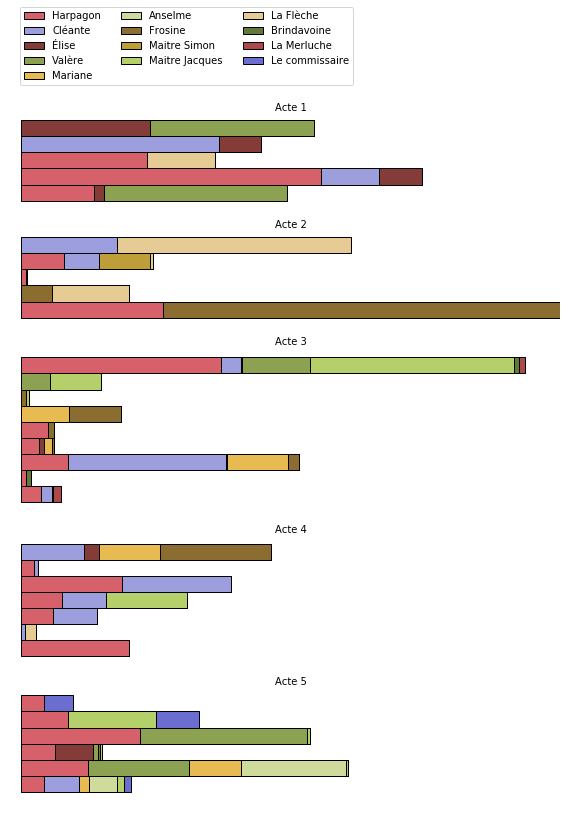

In [17]:
fig, axes = plt.subplots(nrows = len(acts),
                         figsize=(8, 12),
                         gridspec_kw = {'height_ratios': list(map(len, acts))})
fig.tight_layout()
fig.subplots_adjust(left=0.03, top=0.82, hspace=0.25)
colors = plt.get_cmap('tab20b')(2+np.arange(len(characters)))
colors[::2] = colors[::2][::-1]
max_x = 0
for ax, act, scene_wcs in zip(axes, range(len(acts)), word_count):
    ax.set_title(f"Acte {act+1}", fontsize=10)
    data = np.array([[scene_wc[c]
                      for c in characters]
                     for scene_wc in scene_wcs])
    offsets = np.hstack([np.zeros((len(data), 1), np.int),
                         data[:, :-1].cumsum(axis=1)])
    max_x = max(max_x, offsets[:, -1].max())
    for i, character in enumerate(characters.keys()):
        ax.barh(np.arange(len(data)),
                width=data[:, i], left=offsets[:, i],
                color=colors[i], height=1,
                linewidth=1, edgecolor='black',
                label=characters[character]['name'])
for ax in axes:
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_xlim(0, max_x)
axes[0].legend(ncol=3,
               bbox_to_anchor=(-0.01, 1.3),
               loc='lower left',
               fontsize=10)

Une autre vue des même données utilise des lignes de longueurs égales, mais dont la hauteur représente le nombre de mots prononcés en total. La largeur de chaque rectangle indique alors le pourcentage de la scène qu'un acteur occupe.

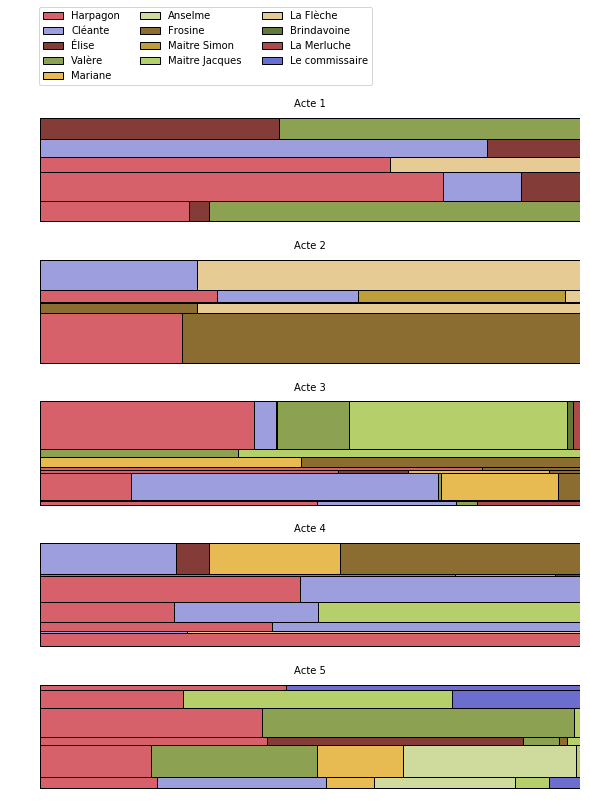

In [18]:
fig, axes = plt.subplots(nrows = len(acts),
                         figsize=(8, 12))
fig.tight_layout()
fig.subplots_adjust(left=0.03, top=0.82, hspace=0.25)
colors = plt.get_cmap('tab20b')(2+np.arange(len(characters)))
colors[::2] = colors[::2][::-1]
for ax, act, scene_wcs in zip(axes, range(len(acts)), word_count):
    ax.set_title(f"Acte {act+1}", fontsize=10)
    data = np.array([[scene_wc[c]
                      for c in characters]
                     for scene_wc in scene_wcs])
    scene_lengths = np.sum(data, axis=1)
    widths = data / scene_lengths[:, np.newaxis]
    heights = scene_lengths
    h_offsets = np.hstack([np.zeros((len(widths), 1), np.float),
                           widths.cumsum(axis=1)])
    assert (np.fabs(h_offsets[:, -1] - 1) < 1.e-10).all()
    v_offsets = np.hstack([[0], heights.cumsum()[:-1]])
    for i, character in enumerate(characters.keys()):
        ax.barh(v_offsets+heights/2,
                width=widths[:, i], left=h_offsets[:, i],
                height=heights,
                color=colors[i],
                linewidth=1, edgecolor='black',
                label=characters[character]['name'])
for ax in axes:
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.axis('off')
    ax.set_xlim(0, 1)
axes[0].legend(ncol=3,
               bbox_to_anchor=(-0.01, 1.2),
               loc='lower left',
               fontsize=10)

## Qui parle à qui ?

La plupart des répliques s'adressent à une personne spécifique, mais il n'est pas facile d'identifier cette personne de façon sure par une analyse du texte. Parfois cette personne est nommée ("Hé quoi, charmante Élise..."), et on pourrait donc envisager d'exploiter les noms contenus dans les répliques. Mais le plus souvent la personne n'est pas nommée, et parfois les acteurs parlent d'une tièrce personne ("Elle se nomme Mariane...").

Nous allons adopter une approche imparfaite mais simple, qui devrait donner une vue globale correcte: on suppose que chaque réplique s'adresse à la personne qui a parlé juste avant.

In [19]:
word_count = defaultdict(lambda: 0)
for scenes in acts:
    for scene in scenes:
        previous = None
        wc = defaultdict(lambda: 0)
        for part in scene:
            current = part['character']
            count = sum(len(line.split()) for line in part['speech'])
            if previous is not None:
                word_count[(current, previous)] += count
            previous = current

L'affichage sous forme de matrice donne une première impression de la diversité dans l'ampleur des échanges :

In [20]:
for c1 in characters:
    print(''.join([str(word_count[(c1, c2)]).rjust(5) for c2 in characters]))

    0 1485  364  857   85  189  607   60  665  434   20  134  118
 1354    0  702   22  305    0  151    0  162  362    0    0    0
  314  195    0  499   26    0    0    0    0    0    0    0    0
 1452    0  677    0    4  265    0    0  159    0    0    0    0
  167  278   36  190    0    0  175    0    0    0    0    0    0
   95    0    0  170  207    0    0    0    8    0    0    0    0
 1501  331   46    0  233    0    0    0   12  116    0    0    0
  102   57    0    0    0    0    0    0    0    0    0    0    0
 1026  148    0  267    0    0   11    0    0    0    0    0  111
  249  883    0    0    0    0  252   13    0    0    0    0    0
   27    0    0    0    0    0    0    0    0    0    0    0    0
    8    0    0   11    0    0    0    0    5    0   17    0    0
  194    0    0    0    0   12    0    0   38    0    0    0    0


Ces données se prêtent à une présentation sous forme d'un graphe. Chaque acteur en est un noeud, représesenté par un cercle dont la superficie indique l'importance de sa prise de parole. Ces cercles ont les mêmes couleurs déjà utilisées ci-dessus pour chaque acteur.

In [21]:
colors = plt.get_cmap('tab20b')(2+np.arange(len(characters)))
colors[::2] = colors[::2][::-1]

character_names = list(characters.keys())

importance = {}
for c1 in characters:
    importance[c1] = 0
    for c2 in characters:
        importance[c1] += word_count[(c1, c2)]
max_importance = max(importance.values())
for c in characters:
    importance[c] /= max_importance
r_sq_min = 0.015**2
r_sq_max = 0.06**2

def radius(c):
    n = character_names[c]
    return np.sqrt(r_sq_min + importance[n]*(r_sq_max-r_sq_min))

def draw_circle(c):
    n = character_names[c]
    r = positions.get(n, None)
    circle = mpatch.Circle(r, radius(c), fc=colors[c])
    ax.add_patch(circle)
    return circle

Le positionnement des cercles est important pour la clarté du graphe, surtout quand nous allons rajouter les arêtes. Il y a des algorithmes pour trouver des positions acceptables, mais ils sont assez compliqués, sans pour autant donner un résultat vraiment satisfaisant. Pour nos 14 acteurs, un placement manuel reste faisable et permet une optimisation fine.

In [22]:
positions = {}
positions['HARPAGON'] = (0.5, 0.5)
positions['VALERE'] = (0.05, 0.5)
positions['CLEANTE'] = (0.5, 0.95)
positions['ELISE'] = (0.15, 0.9)
positions['LA FLECHE'] = (0.9, 0.75)
positions['FROSINE'] = (0.7, 0.75)
positions['MARIANE'] = (0.2, 0.7)
positions['MAITRE SIMON'] = (0.95, 0.5)
positions['MAITRE JACQUES'] = (0.35, 0.2)
positions['ANSELME'] = (0.2, 0.1)
positions['LE COMMISSAIRE'] = (0.6, 0.05)
positions['LA MERLUCHE'] = (0.7, 0.05)
positions['BRINDAVOINE'] = (0.8, 0.1)

Nous pouvons maintenant générer les cercles et la légende.
Les arêtes sont représentés par des flèches transparentes dont la largeur est proportionnelle au nombre de mots qu'un acteur adresse à un autre.

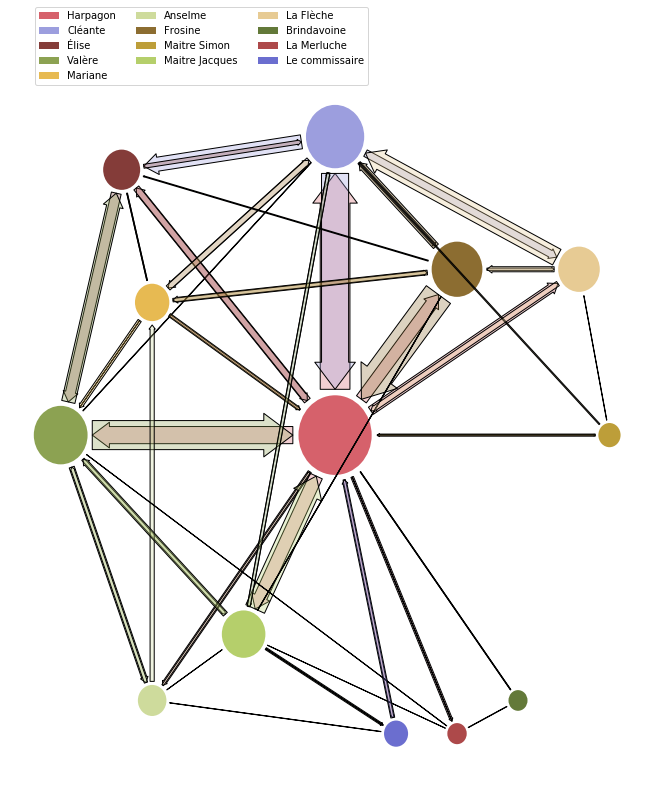

In [23]:
for n in positions:
    positions[n] = np.array(positions[n])

fig, ax = plt.subplots(nrows = 1,
                       figsize=(9, 12))
ax.axis('off')
fig.tight_layout()
fig.subplots_adjust(left=0.03, top=0.8, hspace=0.25)
circles = [draw_circle(c)
           for c in range(len(characters))]
plt.legend(circles,
           [characters[character_names[c]]['name']
            for c in range(len(circles))],
           ncol=3,
           bbox_to_anchor=(0., 1.02),
           loc='lower left',
           fontsize=10)

transparency = np.array([1., 1., 1., 0.3])

def draw_arrow(c1, c2):
    n1 = character_names[c1]
    n2 = character_names[c2]
    r1 = positions.get(n1, None)
    r2 = positions.get(n2, None)
    d = r2-r1
    l = np.sqrt(np.sum(d**2))
    x_tail, y_tail = r1 + 1.1*radius(c1) * d/l
    x_head, y_head = r2 - 1.1*radius(c2) * d/l
    w = word_count[(n1, n2)] / 50.
    astyle = mpatch.ArrowStyle.Simple(head_length=w,
                                      head_width=1.5*w,
                                      tail_width=w)
    arrow = mpatch.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                   arrowstyle=astyle,
                                   fc=colors[c1]*transparency)
    ax.add_patch(arrow)

for c1 in range(len(characters)):
    for c2 in range(len(characters)):
        if c1 != c2:
            draw_arrow(c1, c2)